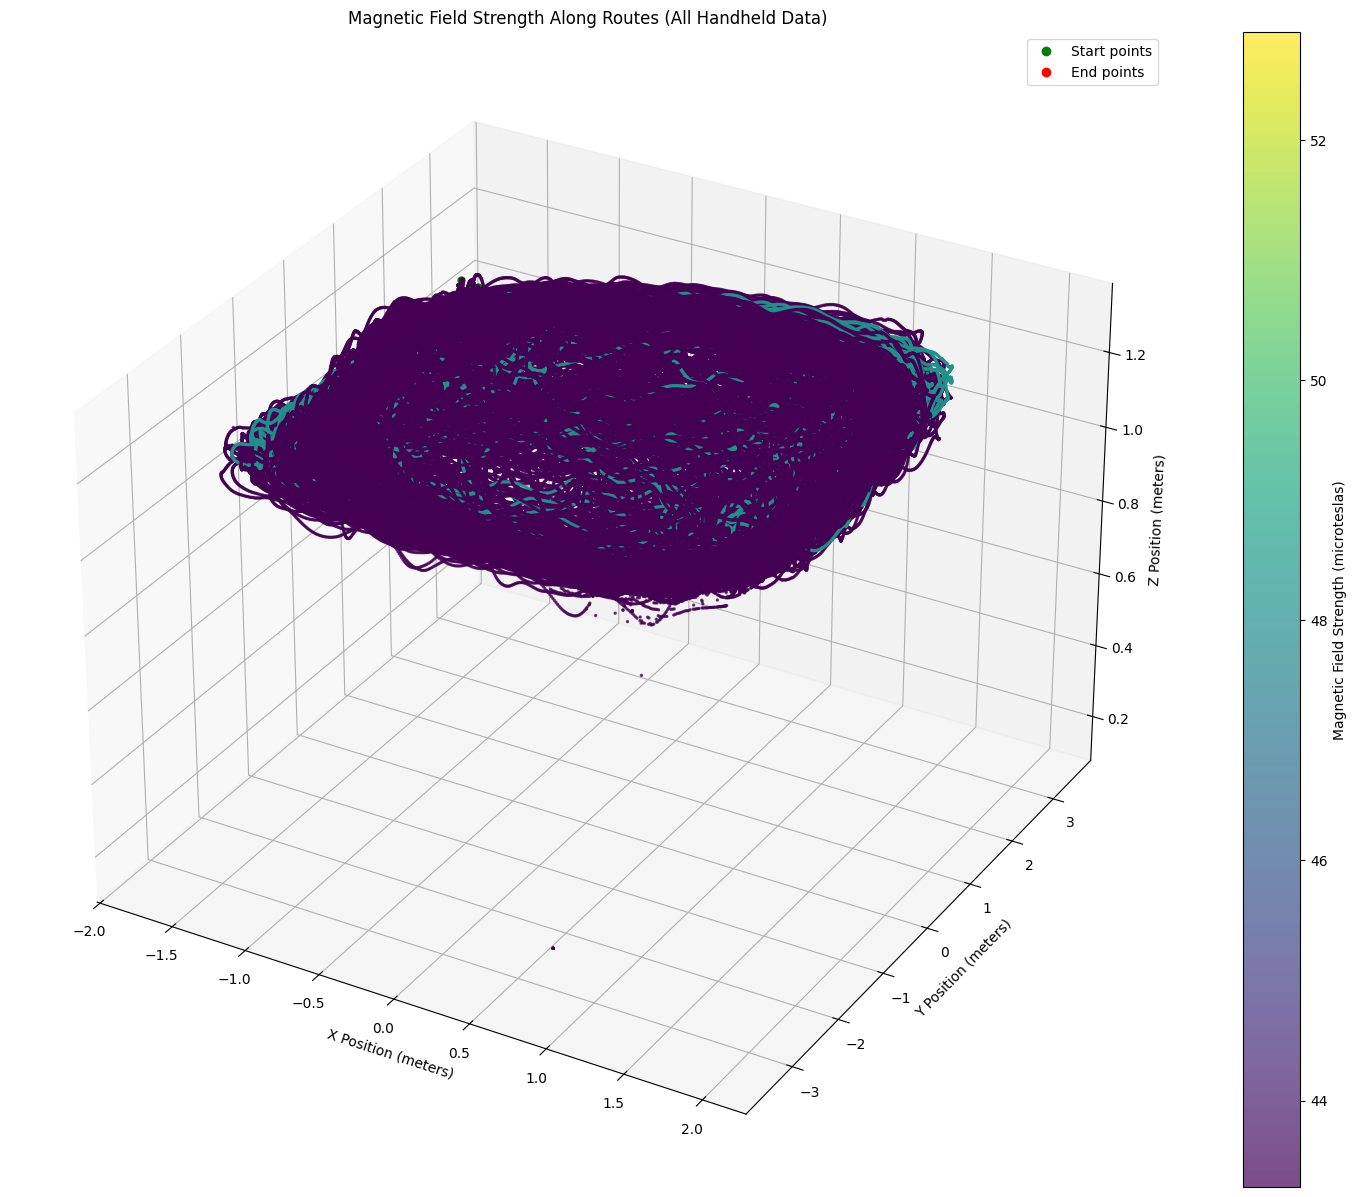

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Base path to the handheld folder
base_path = './data/Oxford Inertial Odometry Dataset/handheld/'

# Function to read and process IMU data
def process_imu_data(file_path):
    df = pd.read_csv(file_path, header=None)
    time = df.iloc[:, 0]
    mag_x, mag_y, mag_z = df.iloc[:, -3], df.iloc[:, -2], df.iloc[:, -1]
    mag_total = np.sqrt(mag_x**2 + mag_y**2 + mag_z**2)
    return time, mag_x, mag_y, mag_z, mag_total

# Function to read and process Vicon data
def process_vicon_data(file_path):
    df = pd.read_csv(file_path, header=None)
    time = df.iloc[:, 0]
    x, y, z = df.iloc[:, 2], df.iloc[:, 3], df.iloc[:, 4]  # X, Y, Z are in 3rd, 4th, and 5th columns
    return time, x, y, z

# Set up the plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Process data for each subfolder
for data_folder in [folder for folder in os.listdir(base_path) if "data" in folder]:
    folder_path = os.path.join(base_path, data_folder, 'syn')
    
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    imu_files = [f for f in os.listdir(folder_path) if f.startswith('imu')]
    vicon_files = [f for f in os.listdir(folder_path) if f.startswith('vi')]

    for imu_file, vicon_file in zip(sorted(imu_files), sorted(vicon_files)):
        imu_time, mag_x, mag_y, mag_z, mag_total = process_imu_data(os.path.join(folder_path, imu_file))
        vicon_time, x, y, z = process_vicon_data(os.path.join(folder_path, vicon_file))

        # Interpolate magnetic field data to match Vicon timestamps
        mag_x_interp = np.interp(vicon_time, imu_time, mag_x)
        mag_y_interp = np.interp(vicon_time, imu_time, mag_y)
        mag_z_interp = np.interp(vicon_time, imu_time, mag_z)
        mag_total_interp = np.interp(vicon_time, imu_time, mag_total)

        # Create a scatter plot
        scatter = ax.scatter(x, y, z, c=mag_total_interp, cmap='viridis', s=2, alpha=0.7)

        # Mark start and end points
        ax.plot([x.iloc[0]], [y.iloc[0]], [z.iloc[0]], 'go', markersize=5)
        ax.plot([x.iloc[-1]], [y.iloc[-1]], [z.iloc[-1]], 'ro', markersize=5)

# Add colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Magnetic Field Strength (microteslas)')

ax.set_title('Magnetic Field Strength Along Routes (All Handheld Data)')
ax.set_xlabel('X Position (meters)')
ax.set_ylabel('Y Position (meters)')
ax.set_zlabel('Z Position (meters)')

# Add legend
ax.plot([], [], [], 'go', label='Start points')
ax.plot([], [], [], 'ro', label='End points')
ax.legend()

plt.show()

In [3]:
import pandas as pd
import numpy as np
import os

# Base path to the handheld folder
base_path = './data/Oxford Inertial Odometry Dataset/handheld/'

# Function to read and process IMU data
def process_imu_data(file_path):
    df = pd.read_csv(file_path, header=None)
    mag_x, mag_y, mag_z = df.iloc[:, -3], df.iloc[:, -2], df.iloc[:, -1]
    mag_total = np.sqrt(mag_x**2 + mag_y**2 + mag_z**2)
    return np.column_stack((mag_x, mag_y, mag_z, mag_total))

# Function to read and process Vicon data
def process_vicon_data(file_path):
    df = pd.read_csv(file_path, header=None)
    x, y, z = df.iloc[:, 2], df.iloc[:, 3], df.iloc[:, 4]
    return np.column_stack((x, y, z))

# Read train and test folder names
with open(os.path.join(base_path, 'Train.txt'), 'r') as f:
    train_folders = f.read().splitlines()
with open(os.path.join(base_path, 'Test.txt'), 'r') as f:
    test_folders = f.read().splitlines()

# Lists to store sequences
X_train, y_train = [], []
X_test, y_test = [], []

# Process data for each folder
for data_folder in train_folders + test_folders:
    folder_path = os.path.join(base_path, data_folder, 'syn')
    
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    imu_files = sorted([f for f in os.listdir(folder_path) if f.startswith('imu')])
    vicon_files = sorted([f for f in os.listdir(folder_path) if f.startswith('vi')])

    for imu_file, vicon_file in zip(imu_files, vicon_files):
        imu_data = process_imu_data(os.path.join(folder_path, imu_file))
        vicon_data = process_vicon_data(os.path.join(folder_path, vicon_file))

        if data_folder in train_folders:
            X_train.append(imu_data)
            y_train.append(vicon_data)
        else:
            X_test.append(imu_data)
            y_test.append(vicon_data)

print("Number of sequences in X_train:", len(X_train))
print("Number of sequences in y_train:", len(y_train))
print("Number of sequences in X_test:", len(X_test))
print("Number of sequences in y_test:", len(y_test))

print("\nShapes of sequences in X_train:")
for i, seq in enumerate(X_train):
    print(f"Sequence {i+1}: {seq.shape}")

print("\nShapes of sequences in X_test:")
for i, seq in enumerate(X_test):
    print(f"Sequence {i+1}: {seq.shape}")

# Calculate and print some statistics
train_lengths = [len(seq) for seq in X_train]
test_lengths = [len(seq) for seq in X_test]

print("\nTraining set statistics:")
print(f"Min length: {min(train_lengths)}")
print(f"Max length: {max(train_lengths)}")
print(f"Mean length: {np.mean(train_lengths):.2f}")
print(f"Median length: {np.median(train_lengths):.2f}")

print("\nTest set statistics:")
print(f"Min length: {min(test_lengths)}")
print(f"Max length: {max(test_lengths)}")
print(f"Mean length: {np.mean(test_lengths):.2f}")
print(f"Median length: {np.median(test_lengths):.2f}")

Number of sequences in X_train: 20
Number of sequences in y_train: 20
Number of sequences in X_test: 4
Number of sequences in y_test: 4

Shapes of sequences in X_train:
Sequence 1: (37602, 4)
Sequence 2: (23446, 4)
Sequence 3: (18850, 4)
Sequence 4: (21641, 4)
Sequence 5: (32160, 4)
Sequence 6: (32537, 4)
Sequence 7: (14098, 4)
Sequence 8: (32618, 4)
Sequence 9: (31179, 4)
Sequence 10: (30059, 4)
Sequence 11: (30756, 4)
Sequence 12: (37910, 4)
Sequence 13: (60868, 4)
Sequence 14: (53796, 4)
Sequence 15: (38322, 4)
Sequence 16: (31724, 4)
Sequence 17: (32228, 4)
Sequence 18: (60580, 4)
Sequence 19: (43841, 4)
Sequence 20: (35017, 4)

Shapes of sequences in X_test:
Sequence 1: (31040, 4)
Sequence 2: (59445, 4)
Sequence 3: (55979, 4)
Sequence 4: (36578, 4)

Training set statistics:
Min length: 14098
Max length: 60868
Mean length: 34961.60
Median length: 32382.50

Test set statistics:
Min length: 31040
Max length: 59445
Mean length: 45760.50
Median length: 46278.50


In [4]:
import numpy as np

# Calculate mean for each dimension in X_train
X_train_all = np.concatenate(X_train, axis=0)
X_train_means = np.mean(X_train_all, axis=0)

# Calculate mean for each dimension in X_test
X_test_all = np.concatenate(X_test, axis=0)
X_test_means = np.mean(X_test_all, axis=0)

# Calculate mean for each dimension in y_train
y_train_all = np.concatenate(y_train, axis=0)
y_train_means = np.mean(y_train_all, axis=0)

# Calculate mean for each dimension in y_test
y_test_all = np.concatenate(y_test, axis=0)
y_test_means = np.mean(y_test_all, axis=0)

print("X_train means:")
print("mag_x:", X_train_means[0])
print("mag_y:", X_train_means[1])
print("mag_z:", X_train_means[2])
print("mag_total:", X_train_means[3])

print("\nX_test means:")
print("mag_x:", X_test_means[0])
print("mag_y:", X_test_means[1])
print("mag_z:", X_test_means[2])
print("mag_total:", X_test_means[3])

print("\ny_train means:")
print("x:", y_train_means[0])
print("y:", y_train_means[1])
print("z:", y_train_means[2])

print("\ny_test means:")
print("x:", y_test_means[0])
print("y:", y_test_means[1])
print("z:", y_test_means[2])

X_train means:
mag_x: -0.46830051313300697
mag_y: -15.668869715403527
mag_z: -36.376663738555756
mag_total: 42.527113564066134

X_test means:
mag_x: -4.326749743812862
mag_y: -13.854210498185887
mag_z: -32.72580701915449
mag_total: 38.786503919304415

y_train means:
x: 0.12568006574318533
y: 0.023374721301369764
z: 1.176188457321701

y_test means:
x: 0.15600621631161352
y: 0.075468841401043
z: 1.1843440265075935


## Do an LSTM Model in Pytorch of The previous 120 window + Feed Output + Residual to predict the `x`, `y` and `z` based on the previous Magnetic, Properly split(entire sequences instead of first splitting into sliding windows then...), also try to basically normalize the data first

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

# Print original shapes
print("Original shapes:")
print(f"X_train: {len(X_train)} sequences")
print(f"X_test: {len(X_test)} sequences")
print(f"y_train: {len(y_train)} sequences")
print(f"y_test: {len(y_test)} sequences")
print(f"First X_train sequence shape: {X_train[0].shape}")
print(f"First y_train sequence shape: {y_train[0].shape}")

Original shapes:
X_train: 20 sequences
X_test: 4 sequences
y_train: 20 sequences
y_test: 4 sequences
First X_train sequence shape: (37602, 4)
First y_train sequence shape: (37602, 3)


# Look I am throwing data away to do a dummy test on CPU

In [7]:
X_train = X_train[:1]  
X_test = X_test[:1]    
y_train = y_train[:1] 
y_test = y_test[:1]    

In [8]:
# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Only use the first 3 columns (mag_x, mag_y, mag_z)
X_train_normalized = [scaler_X.fit_transform(seq[:, :3]) for seq in X_train]
X_test_normalized = [scaler_X.transform(seq[:, :3]) for seq in X_test]
y_train_normalized = [scaler_y.fit_transform(seq) for seq in y_train]
y_test_normalized = [scaler_y.transform(seq) for seq in y_test]

print("\nAfter normalization:")
print(f"X_train_normalized: {len(X_train_normalized)} sequences")
print(f"X_test_normalized: {len(X_test_normalized)} sequences")
print(f"y_train_normalized: {len(y_train_normalized)} sequences")
print(f"y_test_normalized: {len(y_test_normalized)} sequences")
print(f"First X_train_normalized sequence shape: {X_train_normalized[0].shape}")
print(f"First y_train_normalized sequence shape: {y_train_normalized[0].shape}")

# Create sliding windows
def create_sliding_windows(data, targets, window_size=120):
    windows = []
    target_values = []
    for seq, target in zip(data, targets):
        for i in range(len(seq) - window_size):
            windows.append(seq[i:i+window_size])
            target_values.append(target[i+window_size])
    return np.array(windows), np.array(target_values)

X_train_windows, y_train_targets = create_sliding_windows(X_train_normalized, y_train_normalized)
X_test_windows, y_test_targets = create_sliding_windows(X_test_normalized, y_test_normalized)

print("\nAfter creating sliding windows:")
print(f"X_train_windows shape: {X_train_windows.shape}")
print(f"y_train_targets shape: {y_train_targets.shape}")
print(f"X_test_windows shape: {X_test_windows.shape}")
print(f"y_test_targets shape: {y_test_targets.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_windows)
y_train_tensor = torch.FloatTensor(y_train_targets)
X_test_tensor = torch.FloatTensor(X_test_windows)
y_test_tensor = torch.FloatTensor(y_test_targets)

print("\nPyTorch tensor shapes:")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("\nDataLoader information:")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

# Print shape of a single batch
for batch_X, batch_y in train_loader:
    print(f"\nShape of a single batch:")
    print(f"batch_X shape: {batch_X.shape}")
    print(f"batch_y shape: {batch_y.shape}")
    break


After normalization:
X_train_normalized: 1 sequences
X_test_normalized: 1 sequences
y_train_normalized: 1 sequences
y_test_normalized: 1 sequences
First X_train_normalized sequence shape: (37602, 3)
First y_train_normalized sequence shape: (37602, 3)

After creating sliding windows:
X_train_windows shape: (37482, 120, 3)
y_train_targets shape: (37482, 3)
X_test_windows shape: (30920, 120, 3)
y_test_targets shape: (30920, 3)

PyTorch tensor shapes:
X_train_tensor shape: torch.Size([37482, 120, 3])
y_train_tensor shape: torch.Size([37482, 3])
X_test_tensor shape: torch.Size([30920, 120, 3])
y_test_tensor shape: torch.Size([30920, 3])

DataLoader information:
Number of batches in train_loader: 586
Number of batches in test_loader: 484

Shape of a single batch:
batch_X shape: torch.Size([64, 120, 3])
batch_y shape: torch.Size([64, 3])


In [57]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.residual = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        # Residual connection
        residual = self.residual(x[:, -1, :])
        out = out + residual
        
        return out

# Instantiate the model
input_size = 3  # mag_x, mag_y, mag_z
hidden_size = 64
num_layers = 2
output_size = 3  # x, y, z

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [58]:

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (residual): Linear(in_features=3, out_features=3, bias=True)
)

In [59]:
for epoch in range(num_epochs):
    # Evaluation at the start of the epoch
    model.eval()
    with torch.no_grad():
        train_mse = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            outputs_denorm = scaler_y.inverse_transform(outputs.cpu().numpy())
            batch_y_denorm = scaler_y.inverse_transform(batch_y.cpu().numpy())
            mse = np.mean((outputs_denorm - batch_y_denorm) ** 2)
            train_mse += mse
        train_mse /= len(train_loader)
        
        test_mse = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            outputs_denorm = scaler_y.inverse_transform(outputs.cpu().numpy())
            batch_y_denorm = scaler_y.inverse_transform(batch_y.cpu().numpy())
            mse = np.mean((outputs_denorm - batch_y_denorm) ** 2)
            test_mse += mse
        test_mse /= len(test_loader
    
    print(f'Epoch [{epoch}/{num_epochs-1}], '
          f'Train MSE (denorm): {train_mse:.4f}, Test MSE (denorm): {test_mse:.4f}')

    # Training
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch [{epoch}/{num_epochs-1}], Train Loss: {total_loss/len(train_loader):.4f}')

Epoch [0/49], Train MSE (denorm): 1.4946, Test MSE (denorm): 2.5259
Epoch [0/49], Train Loss: 0.3160
Epoch [1/49], Train MSE (denorm): 0.2647, Test MSE (denorm): 3.6559
Epoch [1/49], Train Loss: 0.2283
Epoch [2/49], Train MSE (denorm): 0.1589, Test MSE (denorm): 3.4956


: 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.utils.weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                                    stride=stride, padding=0, dilation=dilation))
        self.chomp1 = Chomp1d((kernel_size-1) * dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                                    stride=stride, padding=0, dilation=dilation))
        self.chomp2 = Chomp1d((kernel_size-1) * dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TCNModel(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCNModel, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, dropout=dropout)]

        self.tcn = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        x = x.transpose(1, 2)
        y1 = self.tcn(x)
        o = self.linear(y1[:, :, -1])
        return o

# Instantiate the model
input_size = 3  # mag_x, mag_y, mag_z
output_size = 3  # x, y, z
num_channels = [32, 64, 128]
kernel_size = 3
dropout = 0.2

model = TCNModel(input_size, output_size, num_channels, kernel_size, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    # Evaluation at the start of the epoch
    model.eval()
    with torch.no_grad():
        train_mse = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            outputs_denorm = scaler_y.inverse_transform(outputs.cpu().numpy())
            batch_y_denorm = scaler_y.inverse_transform(batch_y.cpu().numpy())
            mse = np.mean((outputs_denorm - batch_y_denorm) ** 2)
            train_mse += mse
        train_mse /= len(train_loader)
        
        test_mse = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            outputs_denorm = scaler_y.inverse_transform(outputs.cpu().numpy())
            batch_y_denorm = scaler_y.inverse_transform(batch_y.cpu().numpy())
            mse = np.mean((outputs_denorm - batch_y_denorm) ** 2)
            test_mse += mse
        test_mse /= len(test_loader)
    
    print(f'Epoch [{epoch}/{num_epochs-1}], '
          f'Train MSE (denorm): {train_mse:.4f}, Test MSE (denorm): {test_mse:.4f}')

    # Training
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch [{epoch}/{num_epochs-1}], Train Loss: {total_loss/len(train_loader):.4f}')

/home/user/Code/mlenv/lib64/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


RuntimeError: The size of tensor a (112) must match the size of tensor b (120) at non-singleton dimension 2

In [ ]:
model.eval()
test_loss = 0
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        
        predictions.append(outputs.cpu().numpy())
        actuals.append(batch_y.cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform the predictions and actuals
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(actuals)

mse = np.mean((predictions - actuals)**2)
rmse = np.sqrt(mse)

print(f'Test Loss: {test_loss/len(test_loader):.4f}')
print(f'Test RMSE: {rmse:.4f}')

# Calculate and print Mean Absolute Error (MAE) for each dimension
mae = np.mean(np.abs(predictions - actuals), axis=0)
print(f'MAE for x: {mae[0]:.4f}')
print(f'MAE for y: {mae[1]:.4f}')
print(f'MAE for z: {mae[2]:.4f}')

Test Loss: 1.6254
Test RMSE: 1.6122
MAE for x: 1.1364
MAE for y: 1.8013
MAE for z: 0.0289
